In [3]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

import os
import yaml

from google.cloud import bigquery
from google.cloud import aiplatform as vertex_ai

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
plt.rcParams['font.family'] = 'DejaVu Sans'

In [5]:
# Load configuration
CONFIG_PATH = "../configs/config.yaml"
with open(CONFIG_PATH, 'r') as config_file:
    config = yaml.safe_load(config_file)

# Paths from configuration
PROJECT_ID = config['gcp']['project_id']
LOCATION = config['gcp']['location']
TENSORBOARD_NAME = f"projects/{PROJECT_ID}/locations/{LOCATION}/tensorboards/149744687610068992"


In [6]:
# Set up experiment tracking
vertex_ai.init(
    project=PROJECT_ID,
    location=LOCATION,
    staging_bucket="gs://experiment_tracking_bucket",
    experiment="forcasting-experiment",
    experiment_tensorboard=vertex_ai.Tensorboard(TENSORBOARD_NAME)
)

In [7]:
# Set up BigQuery client
client = bigquery.Client(project="mlops-retail-quant")

# Query the data from BigQuery
query = """
SELECT * FROM `mlops-retail-quant.retail_dataset.raw_data_table`
"""
df = client.query(query).to_dataframe()

# Display the dataframe
df.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536414,22139,None,56,2010-12-01 11:52:00+00:00,0.0,<NA>,United Kingdom
1,536545,21134,None,1,2010-12-01 14:32:00+00:00,0.0,<NA>,United Kingdom
2,536546,22145,None,1,2010-12-01 14:33:00+00:00,0.0,<NA>,United Kingdom
3,536547,37509,None,1,2010-12-01 14:33:00+00:00,0.0,<NA>,United Kingdom
4,536549,85226A,None,1,2010-12-01 14:34:00+00:00,0.0,<NA>,United Kingdom


In [8]:
df.shape

(541909, 8)

In [9]:
df.dtypes

invoice_no                   object
stock_code                   object
description                  object
quantity                      Int64
invoice_date    datetime64[us, UTC]
unit_price                  float64
customer_id                   Int64
country                      object
dtype: object

In [10]:
print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False))

customer_id    135080
description      1454
dtype: int64


In [11]:
df.duplicated().sum()

5268

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   invoice_no    541909 non-null  object             
 1   stock_code    541909 non-null  object             
 2   description   540455 non-null  object             
 3   quantity      541909 non-null  Int64              
 4   invoice_date  541909 non-null  datetime64[us, UTC]
 5   unit_price    541909 non-null  float64            
 6   customer_id   406829 non-null  Int64              
 7   country       541909 non-null  object             
dtypes: Int64(2), datetime64[us, UTC](1), float64(1), object(4)
memory usage: 34.1+ MB


### Data Cleaning

In [13]:
#Removing NaN's in Customer ID
print("Shape of df before removing NaN's CustomerID",df.shape)
df_v2 = df.dropna(subset="customer_id",axis=0)
print("Shape of df after removing NaN's CustomerID",df_v2.shape)

Shape of df before removing NaN's CustomerID (541909, 8)
Shape of df after removing NaN's CustomerID (406829, 8)


In [14]:
print("Missing values in each column after cleaning customerID :\n",df_v2.isnull().sum())

Missing values in each column after cleaning customerID :
 invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64


In [15]:
# after reading invoice_no starts with the 'c' means cancelled transaction
df_v3 = df_v2[~df_v2.invoice_no.str.contains('C',na=False)]
print("Dataset is free from cancelled products information")

Dataset is free from cancelled products information


In [16]:
# Removing duplicates (Values in all columns are identical)
print("Number of duplicates before cleaning:",df_v3.duplicated().sum())
df_v4 = df_v3.drop_duplicates(keep="first")
print("Number of duplicates after cleaning:",df_v4.duplicated().sum())

Number of duplicates before cleaning: 5192
Number of duplicates after cleaning: 0


In [17]:
print("Negative value in Quantity is:",(df_v4.quantity<0).sum())
print("Negative value in Unit Price is:",(df_v4.unit_price<0).sum())

Negative value in Quantity is: 0
Negative value in Unit Price is: 0


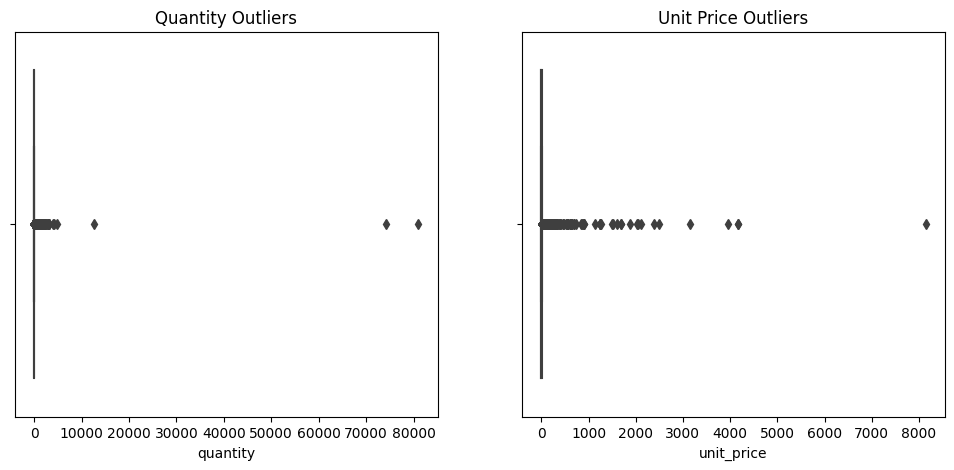

In [18]:
# Boxplot for quantity and unit price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_v4['quantity'])
plt.title('Quantity Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_v4['unit_price'])
plt.title('Unit Price Outliers')

plt.show()

In [19]:
# Define function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from quantity and unit price
df_v5 = remove_outliers(df_v4, 'quantity')
df_v6 = remove_outliers(df_v5, 'unit_price')


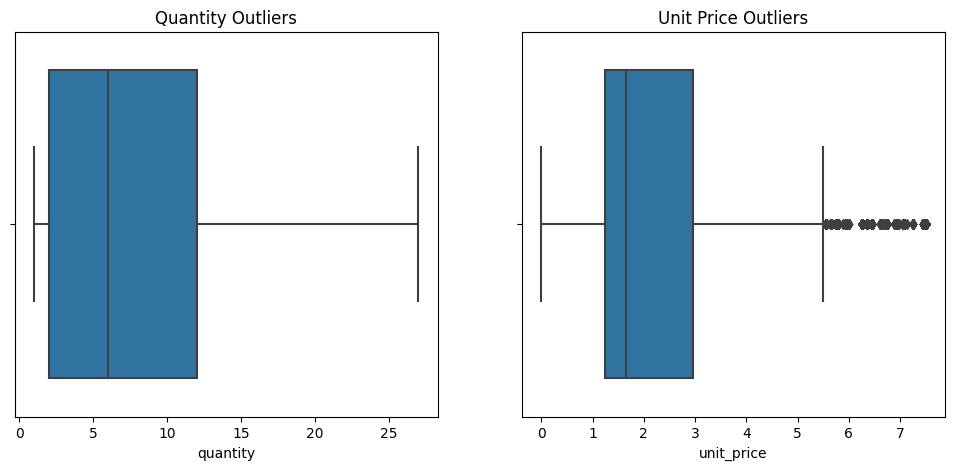

In [20]:
# Boxplot for quantity and unit price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_v6['quantity'])
plt.title('Quantity Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_v6['unit_price'])
plt.title('Unit Price Outliers')

plt.show()

In [21]:
df_v6.shape

(333265, 8)

In [22]:
df_v7 = df_v6.copy()
df_v7['total'] = df_v6['quantity'] * df_v6['unit_price']

In [23]:
daily_sales = df_v7.groupby(df_v7['invoice_date'].dt.date)['total'].sum().reset_index()
daily_sales.columns = ['date', 'total_sales']

In [26]:
daily_sales.head()

,date,total_sales
0,2010-12-01,20502.59
1,2010-12-02,22829.28
2,2010-12-03,11290.71
3,2010-12-05,20735.34
4,2010-12-06,18393.03


In [27]:
# Set the date as the index
daily_sales.set_index('date', inplace=True)

In [28]:
daily_sales.head()

,total_sales
date,
2010-12-01,20502.59
2010-12-02,22829.28
2010-12-03,11290.71
2010-12-05,20735.34
2010-12-06,18393.03


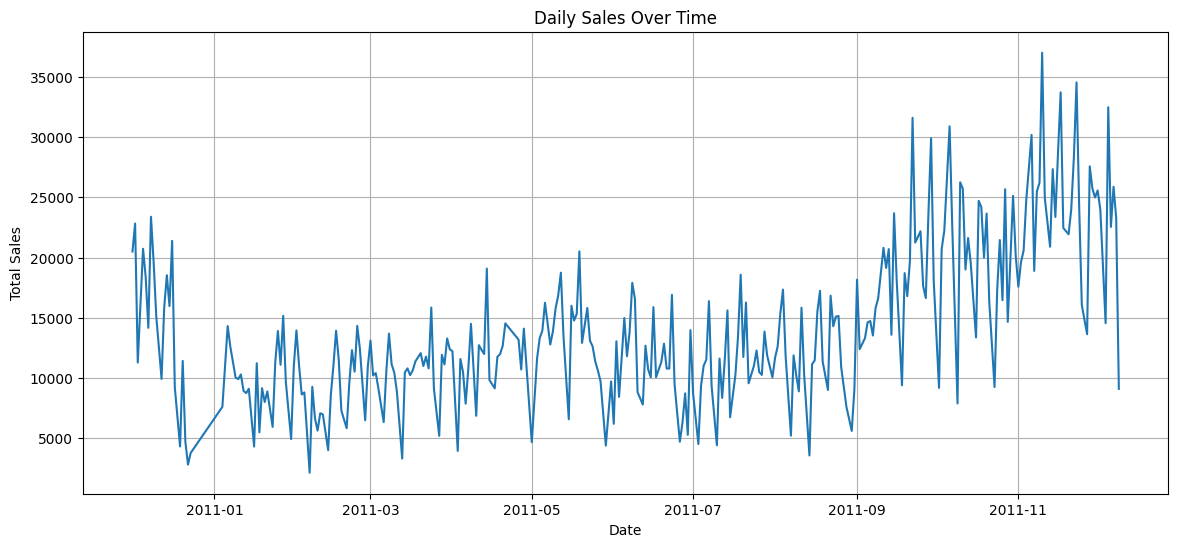

In [29]:
# Step 2: Visualize Sales Data
plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index, daily_sales['total_sales'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [30]:
# Step 3: Prepare Data for Prophet
# Prophet requires columns named 'ds' and 'y'
prophet_data = daily_sales.reset_index().rename(columns={'date': 'ds', 'total_sales': 'y'})

In [31]:
# Step 4: Train the Forecasting Model
# Initialize the model
model = Prophet()

# Fit the model to the data
model.fit(prophet_data)

# Step 5: Make Future Predictions
# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Predict future sales
forecast = model.predict(future)

18:43:40 - cmdstanpy - INFO - Chain [1] start processing
18:43:40 - cmdstanpy - INFO - Chain [1] done processing


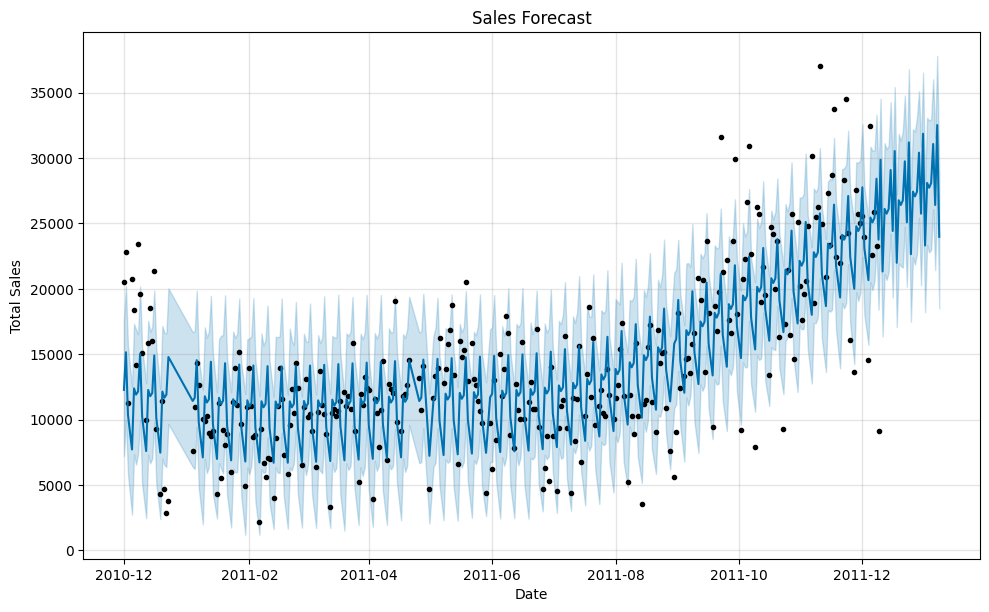

In [32]:
# Step 6: Plot the Forecast
model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

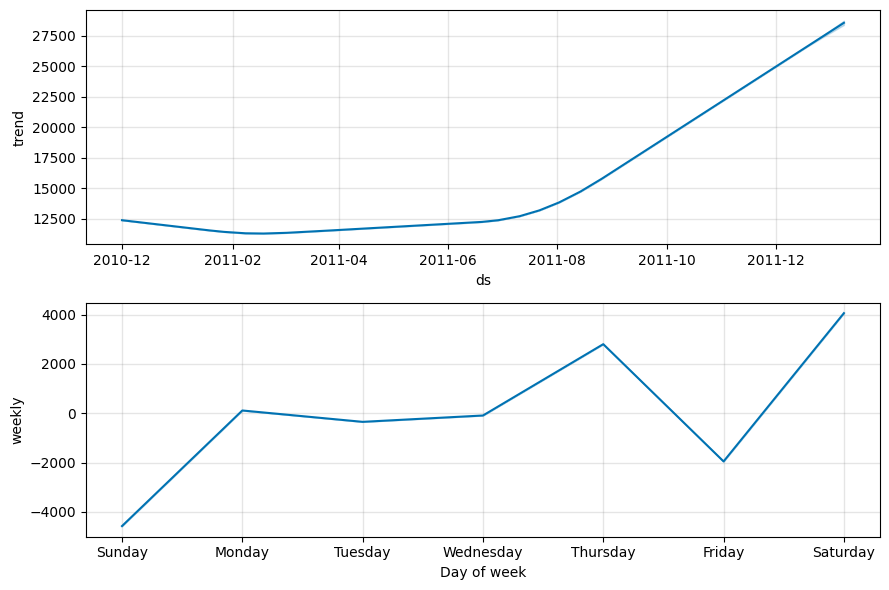

In [33]:
# Step 7: Plot Components to Understand Trend and Seasonality
model.plot_components(forecast)
plt.show()

In [34]:
# Step 8: Evaluate the Model
# Train-test split (use the last 30 days as a test set)
train = prophet_data.iloc[:-30]
test = prophet_data.iloc[-30:]

In [36]:
# Fit the model on the training set
model = Prophet()
model.fit(train)

# Make predictions on the test set
future_test = model.make_future_dataframe(periods=30)
forecast_test = model.predict(future_test)

# Extract the actual predictions and evaluate
y_true = test['y'].values
y_pred = forecast_test['yhat'][-30:].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

18:45:54 - cmdstanpy - INFO - Chain [1] start processing
18:45:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 5192.242330809069
Root Mean Squared Error (RMSE): 6678.830462737752


In [ ]:





# Step 9: Save the Model
import joblib
joblib.dump(model, 'models/sales_forecast_model.pkl')